In [1]:
import numpy as np
import torch
import torch.nn as nn
import h5py as h5
import os
import sys
from deepretina.experiments import loadexpt
import pickle
sys.path.append("../")
from models import PracticalBNCNN, NormedBNCNN, DalesBNCNN, DalesSSCNN, SSCNN, BNCNN, PracticalBNCNN, DalesHybrid
#import metrics
import matplotlib.pyplot as plt
from utils.physiology import Physio
import utils.intracellular as intracellular
import utils.batch_compute as bc
import utils.retinal_phenomena as rp
import utils.stimuli as stimuli
import pyret.filtertools as ft
import scipy
import re
import pickle
from tqdm import tqdm
import gc
import resource
import time
import math

def normalize(x):
    return (x-x.mean())/(x.std()+1e-7)

def retinal_phenomena_figs(bn_cnn):
    rp.step_response(bn_cnn)
    plt.save_fig(os.path.join(folder+"_Analysis", "step_response.png"))
    rp.osr(bn_cnn)
    plt.save_fig(os.path.join(folder+"_Analysis", "osr.png"))
    rp.reversing_grating(bn_cnn)
    plt.save_fig(os.path.join(folder+"_Analysis", "reversing_grating.png"))
    rp.contrast_adaptation(bn_cnn, .35, .05)
    plt.save_fig(os.path.join(folder+"_Analysis", "contrast.png"))
    rp.motion_anticipation(bn_cnn)
    plt.save_fig(os.path.join(folder+"_Analysis", "motion_anticipation.png"))
    
#If you want to use stimulus that isnt just boxes
def prepare_stim(stimuli, stim_type):
    if stim_type == 'boxes':
        return stimuli
    elif stim_type == 'flashes':
        stim = stimuli.reshape(stimuli.shape[0], 1, 1)
        return np.broadcast_to(stim, (stim.shape[0], 38, 38))
    elif stim_type == 'movingbar':
        stim = block_reduce(stimuli, (1,6), func=np.mean)
        stim = pyret.stimulustools.upsample(stim.reshape(stim.shape[0], stim.shape[1], 1), 5)[0]
        return np.broadcast_to(stim, (stim.shape[0], stim.shape[1], stim.shape[1]))
    else:
        return None

## If used metrics

In [2]:
DEVICE = torch.device("cuda:0")
torch.cuda.empty_cache()

In [3]:
cells = [0,1,2,3,4]
dataset = '15-10-07'
test_data = loadexpt(dataset,cells,'naturalscene','test',40,0)
test_x = torch.from_numpy(test_data.X)

Loading testing data for 15-10-07/naturalscene... Done.


In [4]:
#Load data
# num_pots stores the number of cells per stimulus
# mem_pots stores the membrane potential
# psst, you can find the "data" folder in /home/grantsrb on deepretina server
# psssst, note the additional ../ added to each path in files

files = ['../data/bipolars_late_2012.h5', '../data/bipolars_early_2012.h5', '../data/amacrines_early_2012.h5', '../data/amacrines_late_2012.h5', '../data/horizontals_early_2012.h5', '../data/horizontals_late_2012.h5']
files = ["../" + name for name in files]
file_ids = []
for f in files:
    file_ids.append(re.split('_|\.', f)[0])
filter_length = 40
window_size = 2
stims = []
mem_pots = []
num_pots = []
for fi in files:
    with h5.File(fi, 'r') as f:
        num = np.array(f['boxes/detrended_membrane_potential'].shape[0])
        num_pots.append(num)
        stims.append(prepare_stim(np.array(f['boxes/stimuli']), 'boxes'))
        mem_pots.append(np.array(f['boxes/detrended_membrane_potential'])[:, filter_length:])

In [5]:
grand_folder = "scaleshift"
exp_folder = "../training_scripts/"+grand_folder
_, model_folders, _ = next(os.walk(exp_folder))
for i,f in enumerate(model_folders):
    model_folders[i] = grand_folder + "/" + f

In [7]:
model_folders = sorted(model_folders)
print("\n".join(model_folders))

scaleshift/scaleshift_0_lr0.001_l10.001_l20.01
scaleshift/scaleshift_0_lr0.001_l11.5e-05
scaleshift/scaleshift_10_lr0.0001_l11e-06_l20.01
scaleshift/scaleshift_11_lr0.0001_l11e-06_l20.001
scaleshift/scaleshift_12_lr1e-05_l10.001_l20.01
scaleshift/scaleshift_13_lr1e-05_l10.001_l20.001
scaleshift/scaleshift_14_lr1e-05_l11.5e-05_l20.01
scaleshift/scaleshift_15_lr1e-05_l11.5e-05_l20.001
scaleshift/scaleshift_16_lr1e-05_l11e-06_l20.01
scaleshift/scaleshift_17_lr1e-05_l11e-06_l20.001
scaleshift/scaleshift_1_lr0.001_l10.001_l20.001
scaleshift/scaleshift_2_lr0.001_l11.5e-05_l20.01
scaleshift/scaleshift_3_lr0.001_l11.5e-05_l20.001
scaleshift/scaleshift_4_lr0.001_l11e-06_l20.01
scaleshift/scaleshift_5_lr0.001_l11e-06_l20.001
scaleshift/scaleshift_6_lr0.0001_l10.001_l20.01
scaleshift/scaleshift_7_lr0.0001_l10.001_l20.001
scaleshift/scaleshift_8_lr0.0001_l11.5e-05_l20.01
scaleshift/scaleshift_9_lr0.0001_l11.5e-05_l20.001


In [11]:
file = "../training_scripts/"+model_folders[0]+"/test_epoch_0.pth"
try:
    with open(file, "rb") as fd:
        temp = torch.load(fd)
except:
    pass

temp['model']

SSCNN(
  (sequential): Sequential(
    (0): Conv2d(40, 8, kernel_size=(15, 15), stride=(1, 1))
    (1): ScaleShift(shape=(8, 36, 36), scale=True, shift=True)
    (2): GaussianNoise(std=0.05)
    (3): ReLU()
    (4): Conv2d(8, 8, kernel_size=(11, 11), stride=(1, 1))
    (5): ScaleShift(shape=(8, 26, 26), scale=True, shift=True)
    (6): GaussianNoise(std=0.05)
    (7): ReLU()
    (8): Flatten()
    (9): Linear(in_features=5408, out_features=5, bias=True)
    (10): ScaleShift(shape=5, scale=True, shift=True)
    (11): Softplus(beta=1, threshold=20)
  )
)

In [ ]:
conv_layers = ['sequential.0', 'sequential.4']

In [9]:
n_epochs = 250
best_folder_by_loss = ""
best_loss = 100
best_folder_by_val_loss = ""
best_val_loss = 100
best_folder_by_val_acc = ""
best_val_acc = -100
best_folder_by_test_acc = ""
best_test_acc = -100
best_folder_by_intr_cor = ""
best_intr_cor = -1

In [10]:
gc.collect()
max_mem_used = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
print("Memory Used: {:.2f} mb".format(max_mem_used / 1024))

Memory Used: 1031.87 mb


Folder: scaleshift/scaleshift_0_lr0.001_l10.001_l20.01
Final Loss: -2.4634190624296037
Final Val: -1.5649061352014542
Final Val Acc: 0.24074272215366363
Final Test Acc: 0.689372815365142


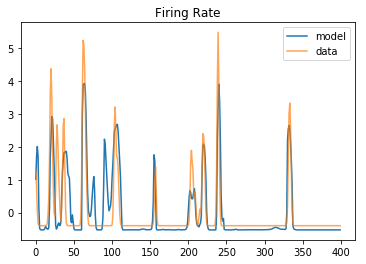

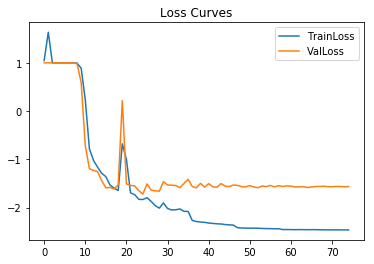

100%|██████████| 10/10 [00:00<00:00, 98.91it/s]
51it [00:00, 250.16it/s]


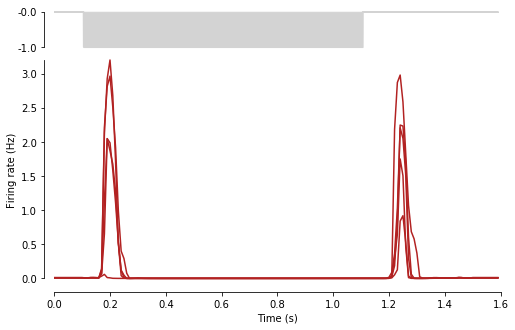

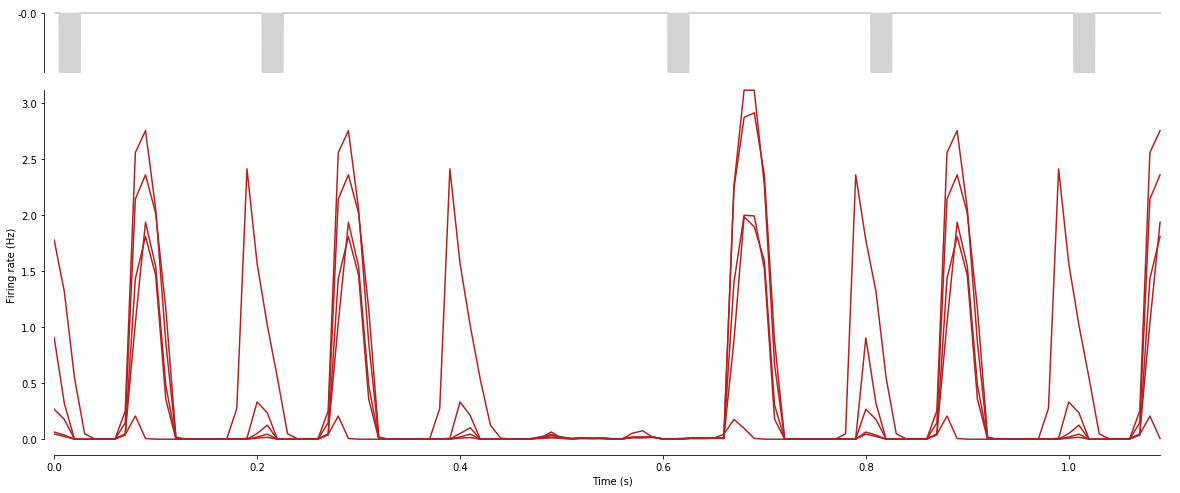

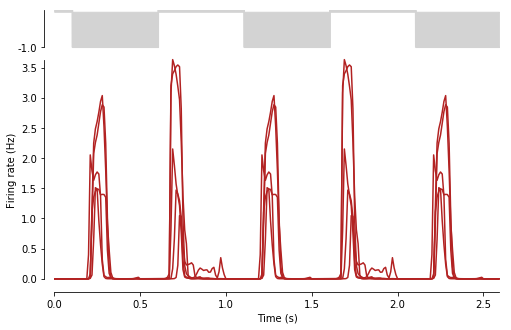

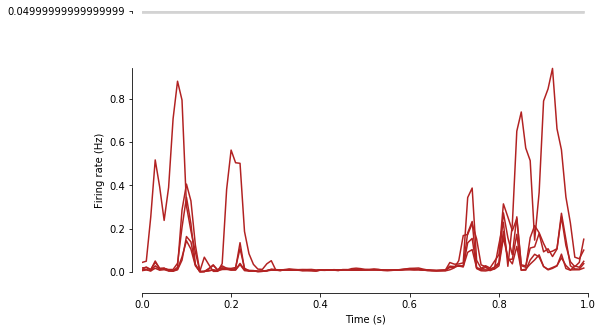

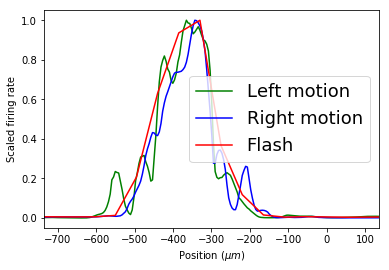

Calculating intercellular correlations...


100%|██████████| 6/6 [02:25<00:00, 24.37s/it]


Mean intercellular: nan
Std intercellular: nan
Min intercellular: nan
Max intercellular: nan
Layer 0 correlation map


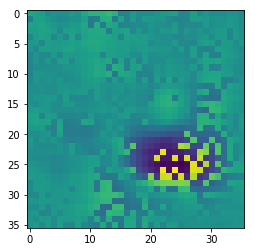

Layer 1 correlation map


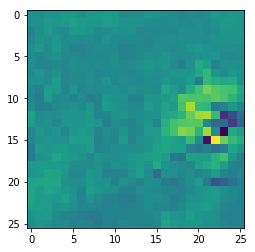

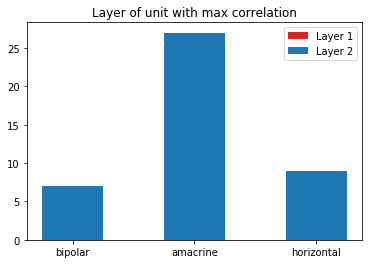

Receptive field of model cell in Layer 0


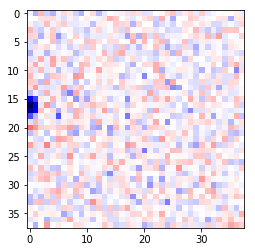

Receptive field of model cell in Layer 1


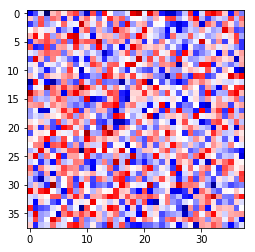

Memory Used: 23138.26 memory
Completed in 226.62295269966125 seconds





Folder: scaleshift/scaleshift_0_lr0.001_l11.5e-05
Final Loss: -1.5315083903492306
Final Val: -0.9549724273383617
Final Val Acc: 0.17330580204725266
Final Test Acc: 0.4329072991012234


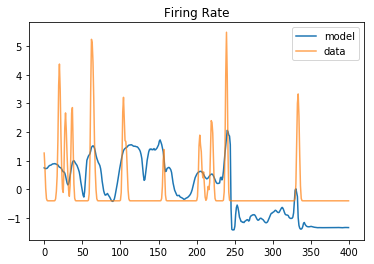

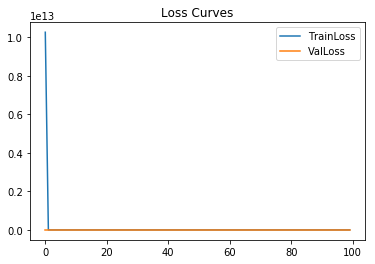

100%|██████████| 10/10 [00:00<00:00, 97.25it/s]
51it [00:00, 250.01it/s]


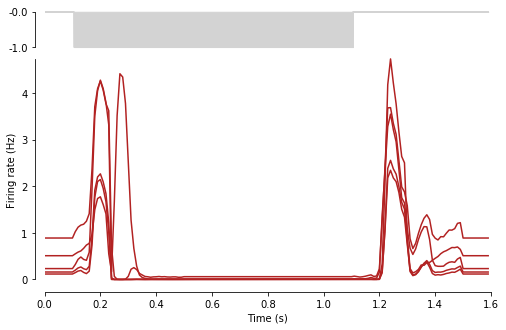

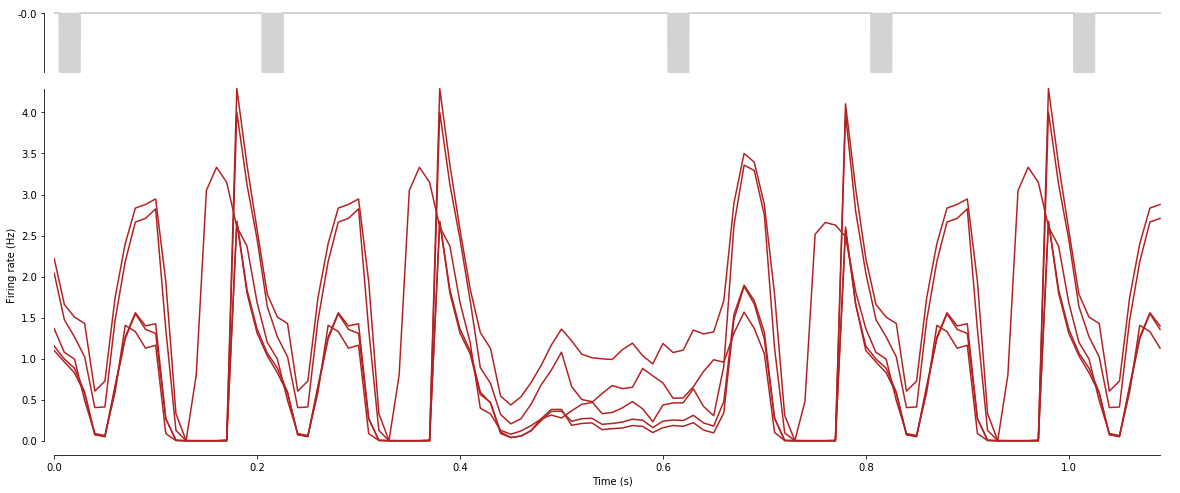

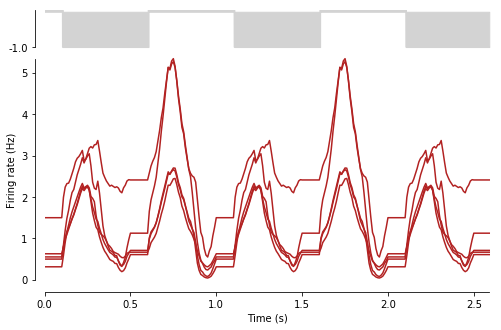

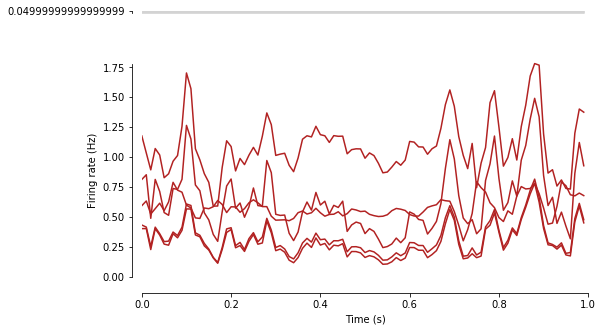

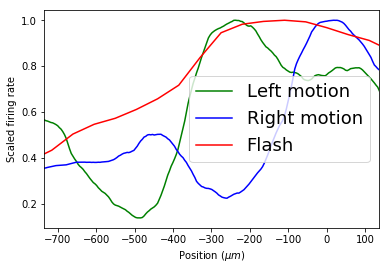

Calculating intercellular correlations...


100%|██████████| 6/6 [02:25<00:00, 24.38s/it]


Mean intercellular: 0.39020124392413075
Std intercellular: 0.15910282399497674
Min intercellular: 0.1115709344791547
Max intercellular: 0.5640745832948821
Layer 0 correlation map


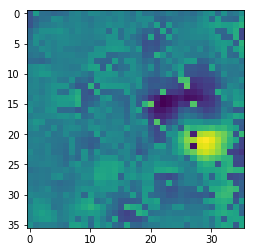

Layer 1 correlation map


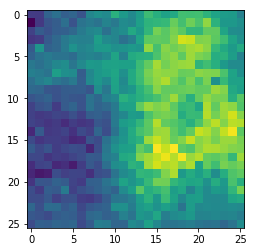

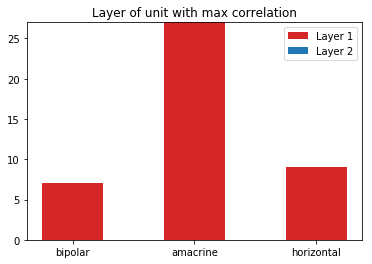

Receptive field of model cell in Layer 0


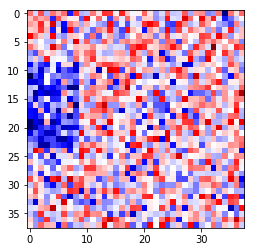

Receptive field of model cell in Layer 1


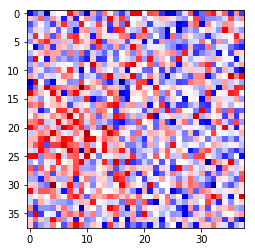

Memory Used: 23138.26 memory
Completed in 226.5019302368164 seconds





Folder: scaleshift/scaleshift_10_lr0.0001_l11e-06_l20.01
Final Loss: -3.199815031629882
Final Val: -1.8815754055976868
Final Val Acc: 0.24881659150123597
Final Test Acc: 0.7100849016939004


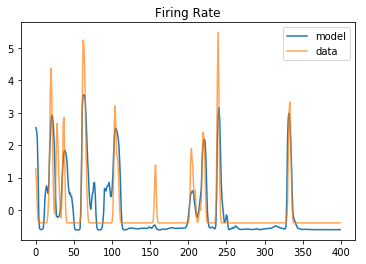

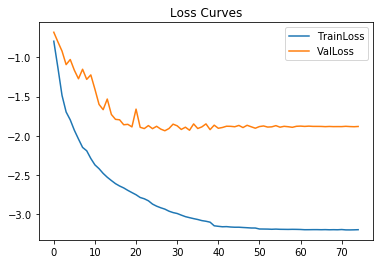

100%|██████████| 10/10 [00:00<00:00, 106.18it/s]
51it [00:00, 268.36it/s]


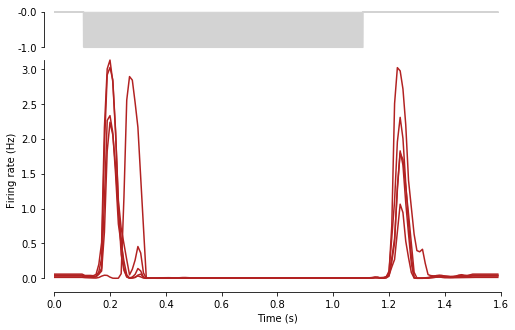

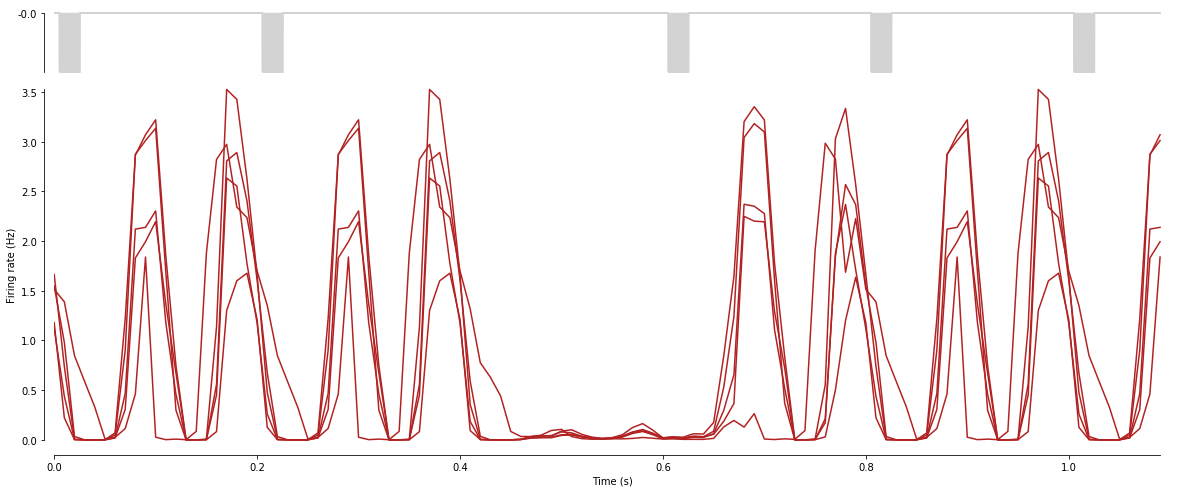

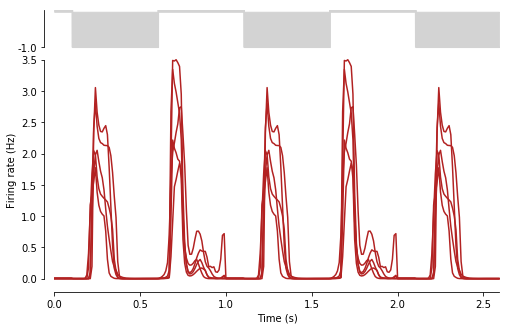

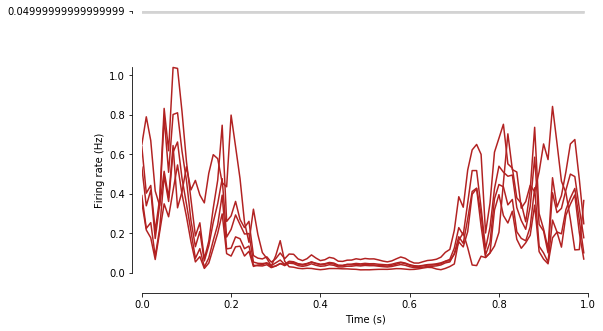

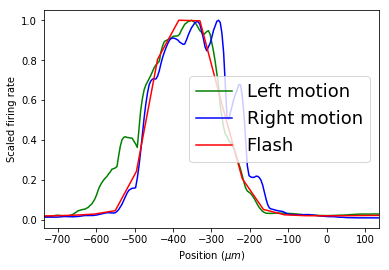

Calculating intercellular correlations...


100%|██████████| 6/6 [02:28<00:00, 25.00s/it]


Mean intercellular: 0.35957814314252545
Std intercellular: 0.13119231128312595
Min intercellular: 0.16139817085477706
Max intercellular: 0.5322795890144639
Layer 0 correlation map


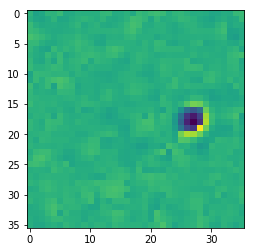

Layer 1 correlation map


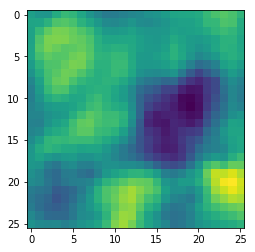

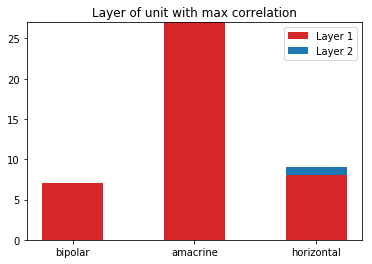

Receptive field of model cell in Layer 0


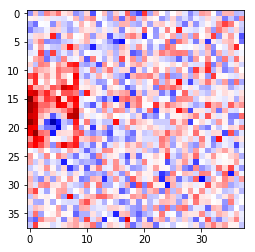

Receptive field of model cell in Layer 1


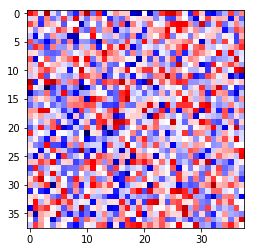

Memory Used: 23138.26 memory
Completed in 228.62198448181152 seconds





Folder: scaleshift/scaleshift_11_lr0.0001_l11e-06_l20.001
Final Loss: -3.6148166505459747
Final Val: -1.8523718416690826
Final Val Acc: 0.2374926656484604
Final Test Acc: 0.7093914685911121


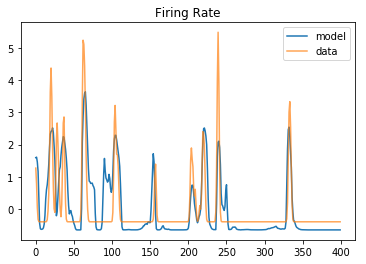

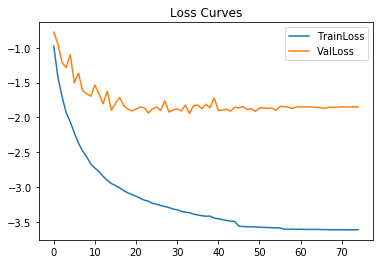

100%|██████████| 10/10 [00:00<00:00, 106.32it/s]
51it [00:00, 266.65it/s]


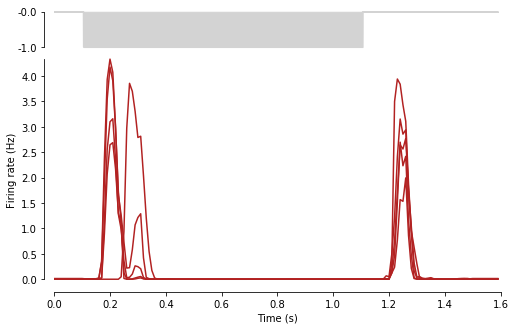

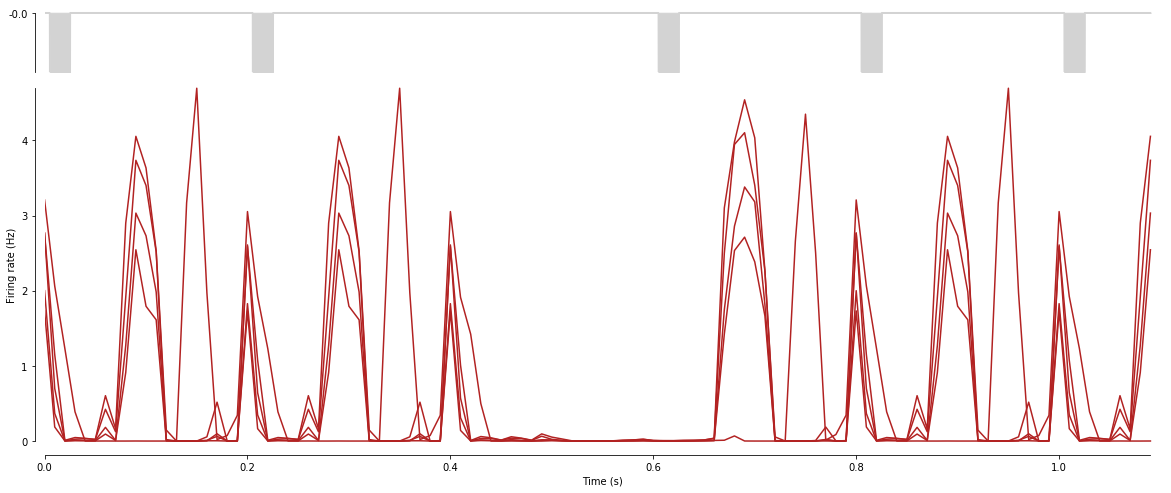

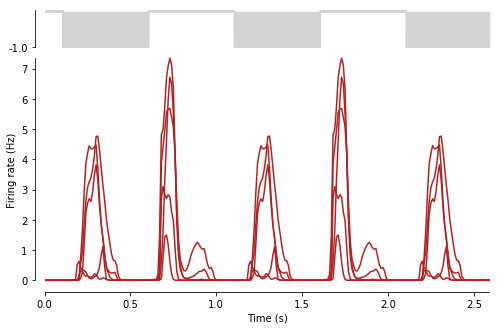

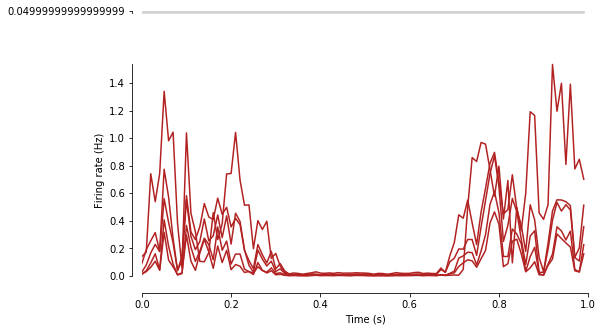

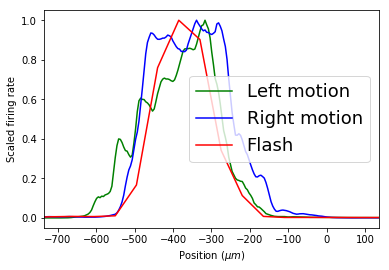

Calculating intercellular correlations...


100%|██████████| 6/6 [02:27<00:00, 24.84s/it]


Mean intercellular: 0.3083121853350059
Std intercellular: 0.15742949198600395
Min intercellular: 0.11856015141492422
Max intercellular: 0.5414023233478986
Layer 0 correlation map


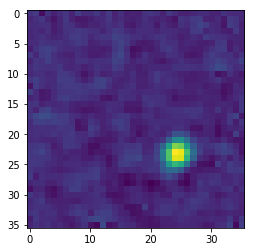

Layer 1 correlation map


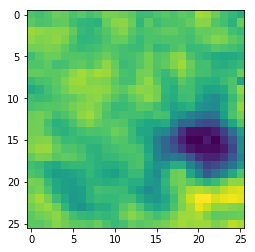

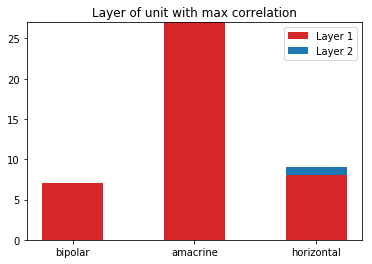

Receptive field of model cell in Layer 0


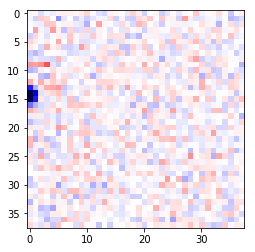

Receptive field of model cell in Layer 1


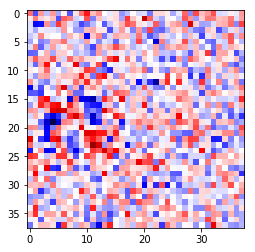

Memory Used: 23203.77 memory
Completed in 226.4231081008911 seconds





Folder: scaleshift/scaleshift_12_lr1e-05_l10.001_l20.01
Final Loss: -1.6647153478312458
Final Val: -1.4257049225270748
Final Val Acc: 0.22199935615062713
Final Test Acc: 0.5987121564377391


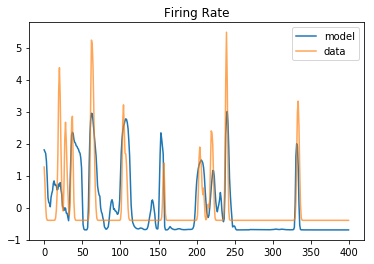

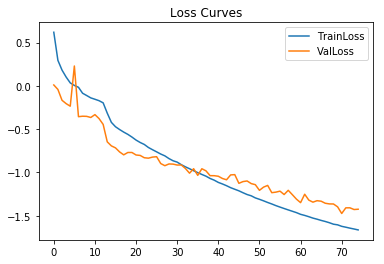

100%|██████████| 10/10 [00:00<00:00, 105.89it/s]
51it [00:00, 271.81it/s]


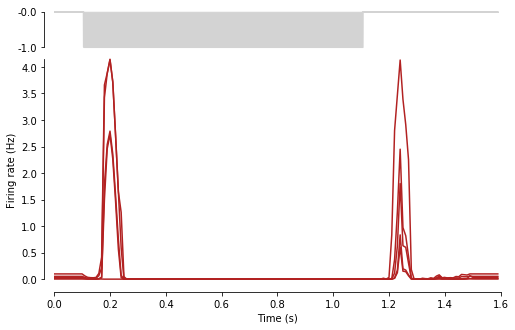

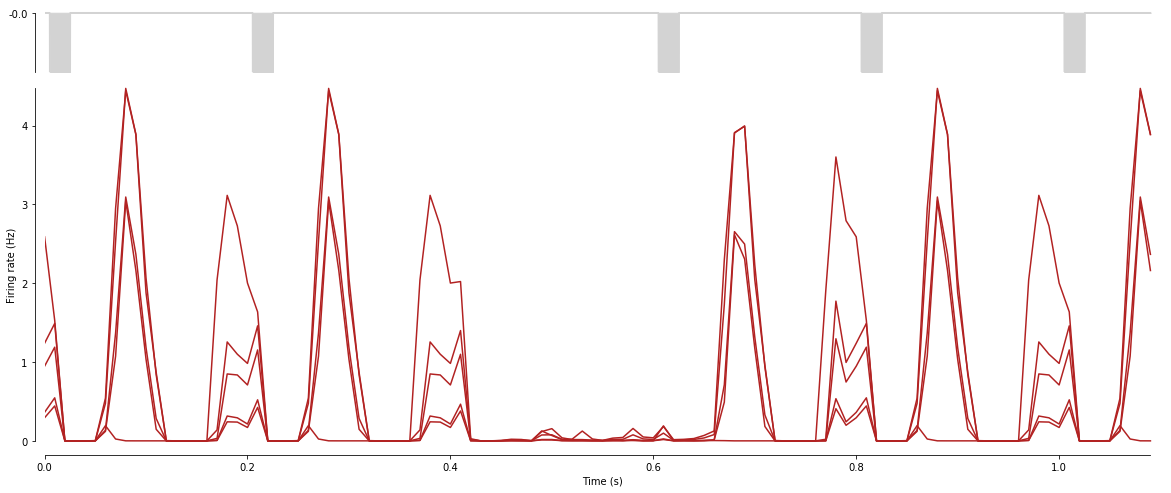

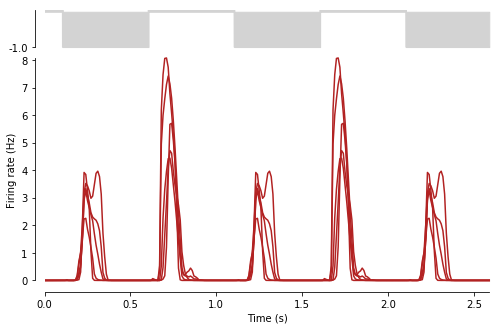

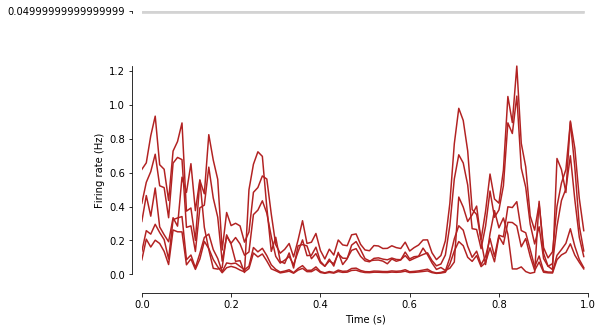

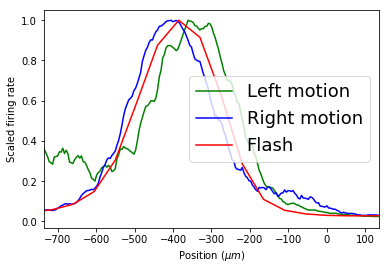

Calculating intercellular correlations...


100%|██████████| 6/6 [02:27<00:00, 24.86s/it]


Mean intercellular: 0.4021818160846227
Std intercellular: 0.1848105442400132
Min intercellular: 0.10968390685240462
Max intercellular: 0.6346436160949097
Layer 0 correlation map


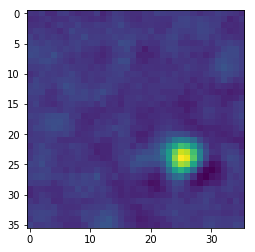

Layer 1 correlation map


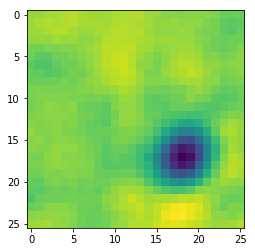

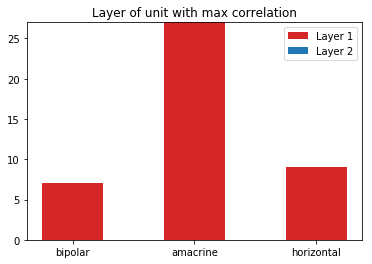

Receptive field of model cell in Layer 0


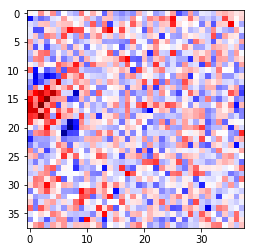

Receptive field of model cell in Layer 1


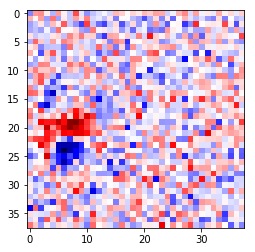

Memory Used: 23203.77 memory
Completed in 228.29845786094666 seconds





Folder: scaleshift/scaleshift_13_lr1e-05_l10.001_l20.001
Final Loss: -1.8354401170398316
Final Val: -1.6225657165050507
Final Val Acc: 0.22884992957115174
Final Test Acc: 0.6258389484601341


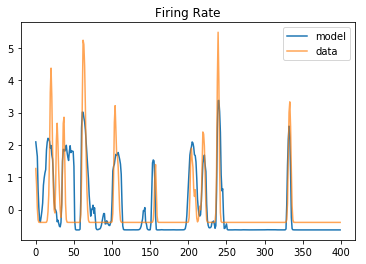

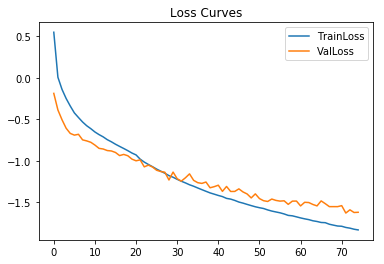

100%|██████████| 10/10 [00:00<00:00, 96.92it/s]
51it [00:00, 238.48it/s]


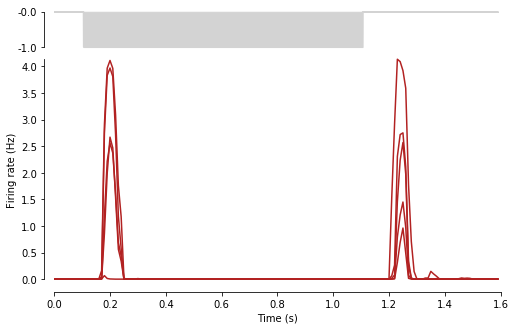

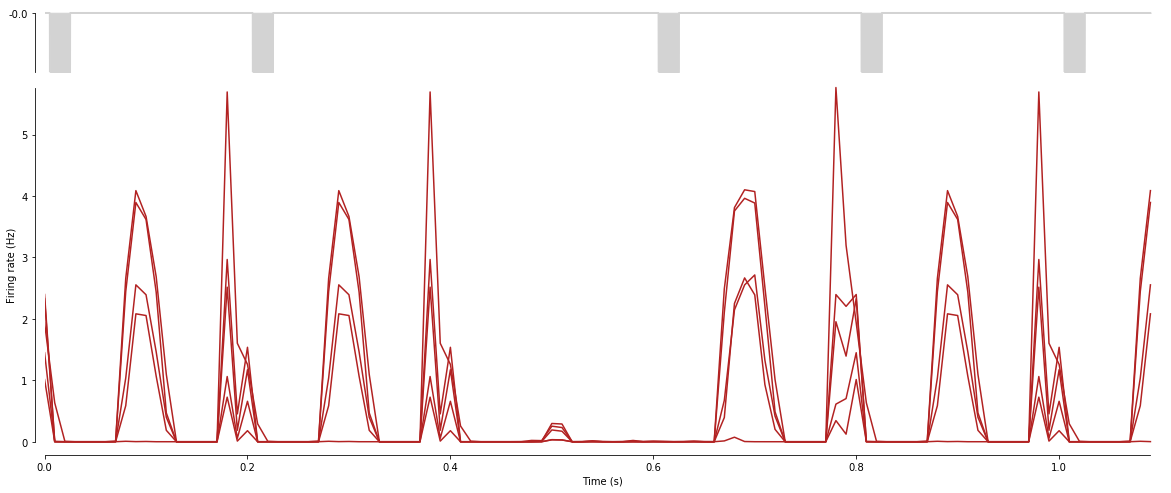

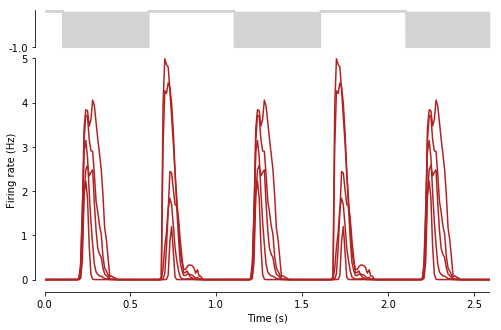

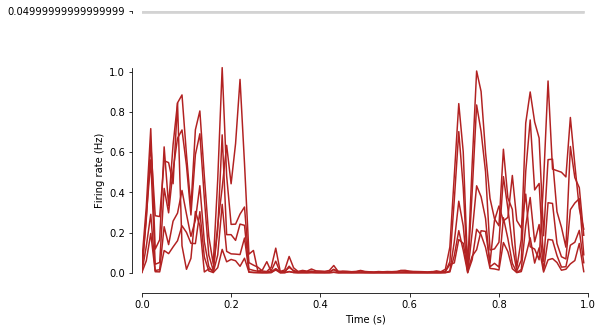

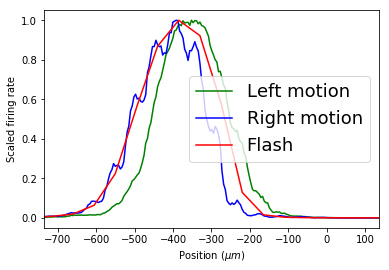

Calculating intercellular correlations...


100%|██████████| 6/6 [02:27<00:00, 24.84s/it]


Mean intercellular: 0.33527164373955054
Std intercellular: 0.16713301831793673
Min intercellular: 0.09186882121590614
Max intercellular: 0.5442020834348871
Layer 0 correlation map


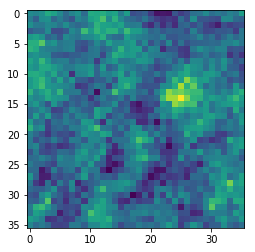

Layer 1 correlation map


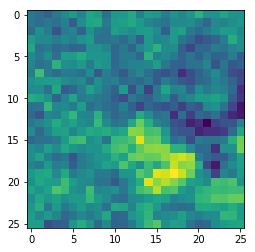

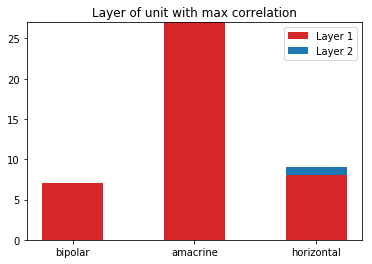

Receptive field of model cell in Layer 0


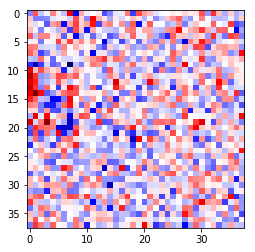

Receptive field of model cell in Layer 1


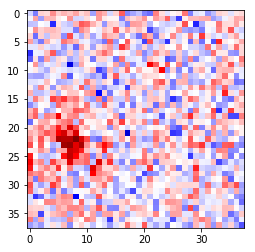

Memory Used: 23203.77 memory
Completed in 230.6179940700531 seconds





Folder: scaleshift/scaleshift_14_lr1e-05_l11.5e-05_l20.01
Final Loss: -2.6950158038110574
Final Val: -1.7456312030553818
Final Val Acc: 0.2268190234899521
Final Test Acc: 0.6183397125357086


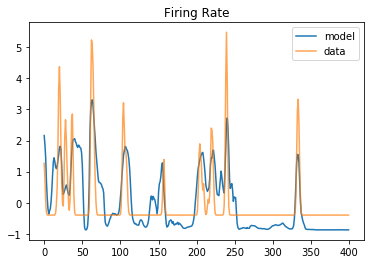

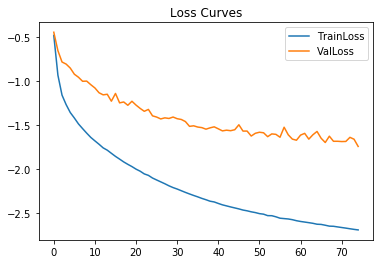

100%|██████████| 10/10 [00:00<00:00, 107.32it/s]
51it [00:00, 269.73it/s]


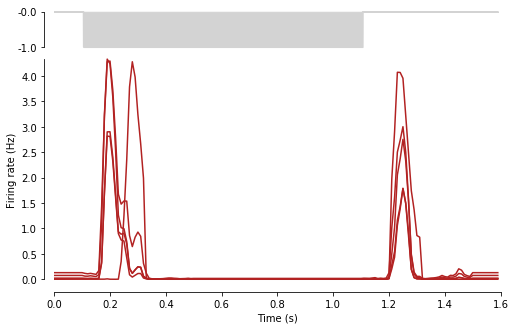

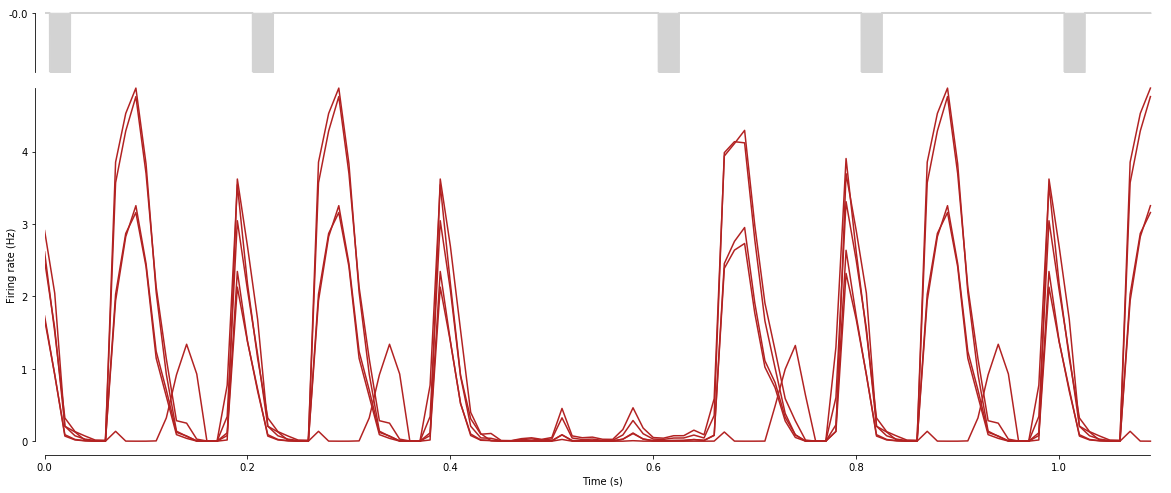

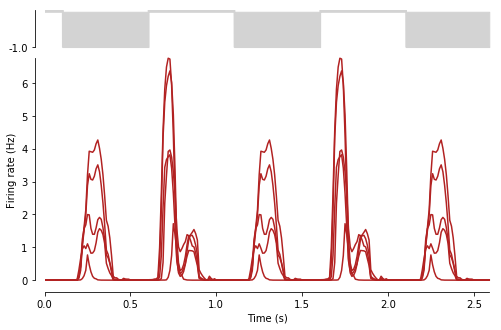

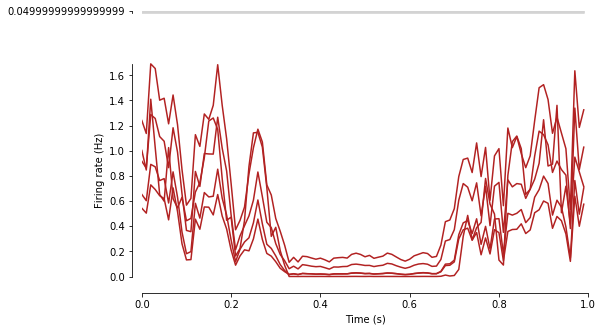

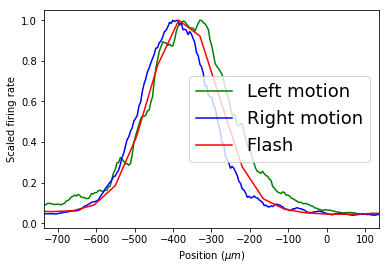

Calculating intercellular correlations...


100%|██████████| 6/6 [02:28<00:00, 24.92s/it]


Mean intercellular: 0.3835556997571837
Std intercellular: 0.16776328700961451
Min intercellular: 0.1309191497939621
Max intercellular: 0.6124628185404091
Layer 0 correlation map


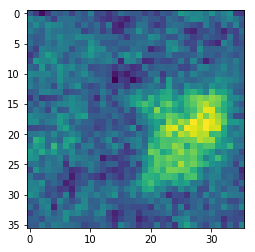

Layer 1 correlation map


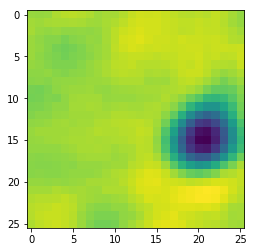

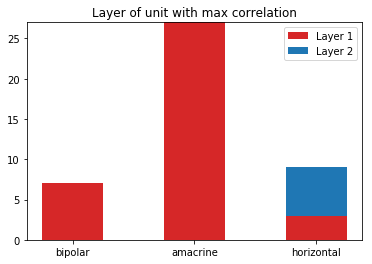

Receptive field of model cell in Layer 0


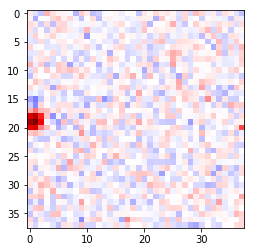

Receptive field of model cell in Layer 1


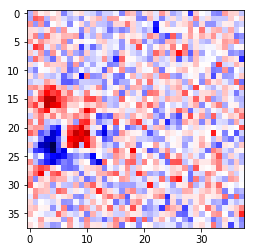

Memory Used: 23203.77 memory
Completed in 230.5174264907837 seconds





Folder: scaleshift/scaleshift_15_lr1e-05_l11.5e-05_l20.001
Final Loss: -2.7414672222791934
Final Val: -1.6938060894608498
Final Val Acc: 0.22175245583057404
Final Test Acc: 0.5967120554414447


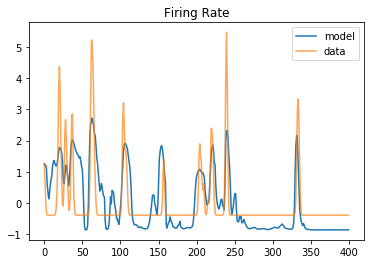

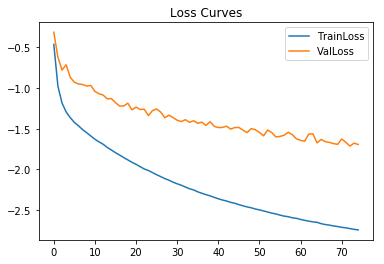

100%|██████████| 10/10 [00:00<00:00, 97.05it/s]
51it [00:00, 246.01it/s]


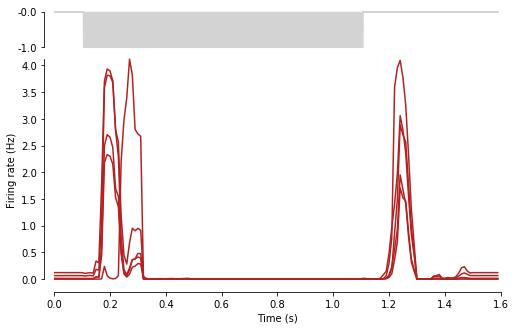

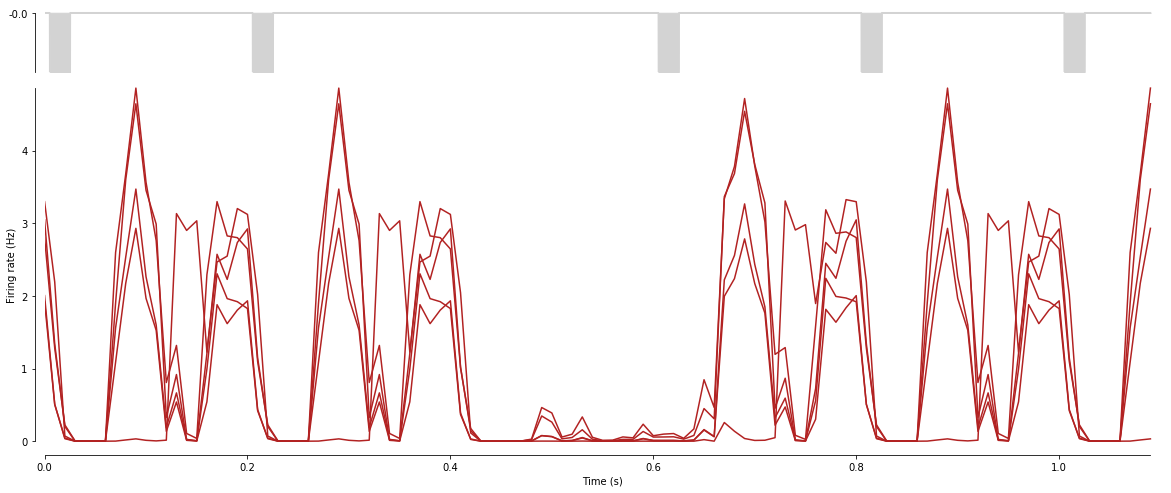

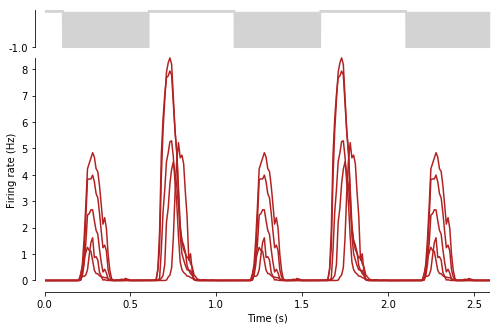

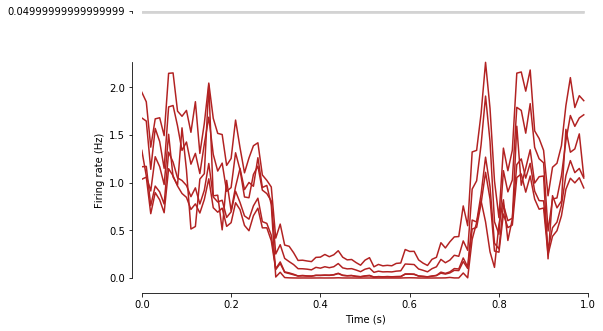

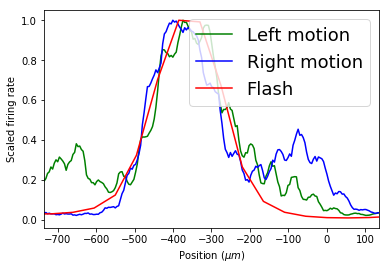

Calculating intercellular correlations...


100%|██████████| 6/6 [02:28<00:00, 24.91s/it]


Mean intercellular: 0.39784677197845575
Std intercellular: 0.13292695555926476
Min intercellular: 0.16634535398113648
Max intercellular: 0.5803325854574765
Layer 0 correlation map


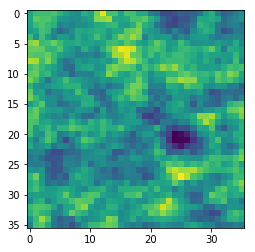

Layer 1 correlation map


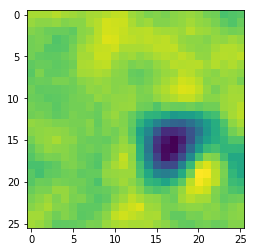

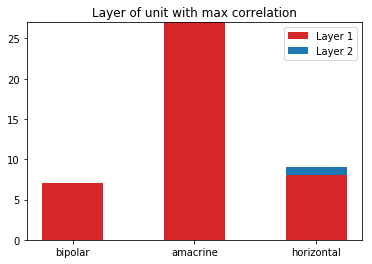

Receptive field of model cell in Layer 0


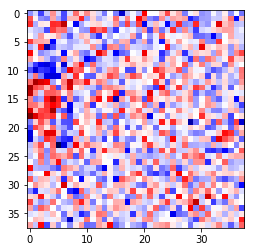

Receptive field of model cell in Layer 1


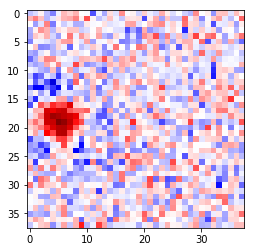

Memory Used: 23203.77 memory
Completed in 229.9718737602234 seconds





Folder: scaleshift/scaleshift_16_lr1e-05_l11e-06_l20.01
Final Loss: -2.6371132377226068
Final Val: -1.6377380564808846
Final Val Acc: 0.2195628136396408
Final Test Acc: 0.5944789789588277


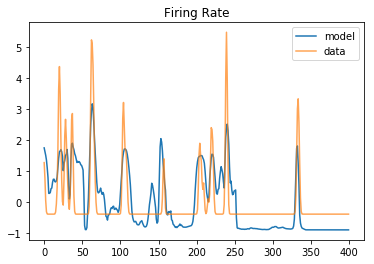

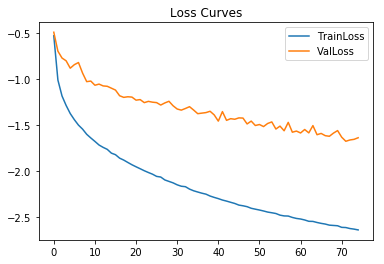

100%|██████████| 10/10 [00:00<00:00, 92.52it/s]
51it [00:00, 245.89it/s]


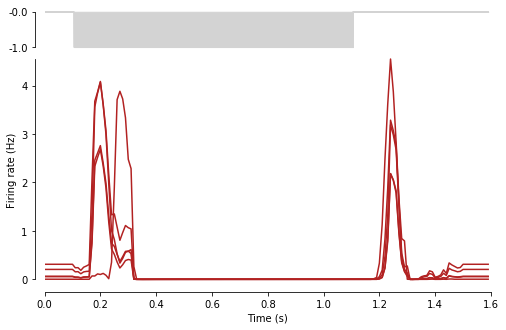

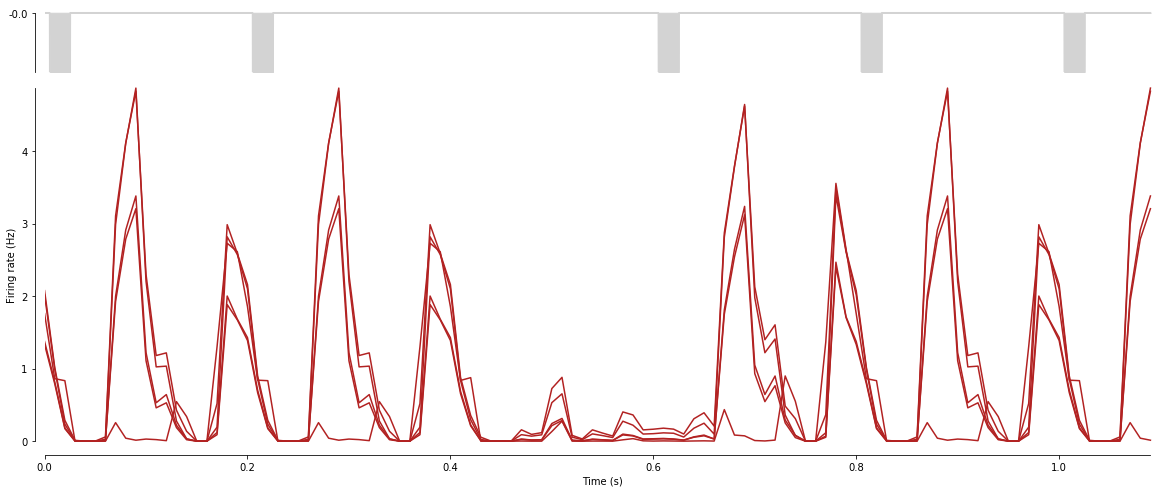

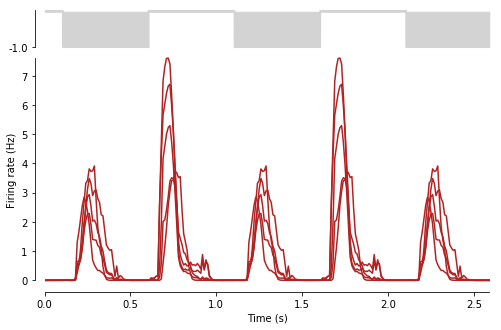

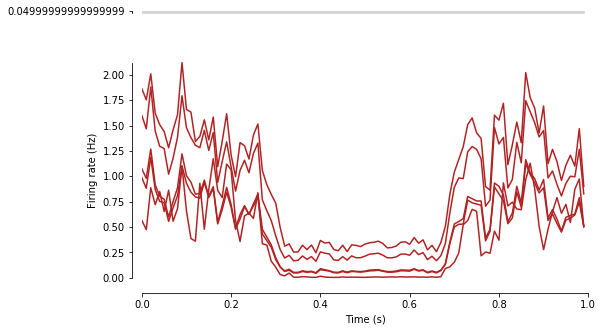

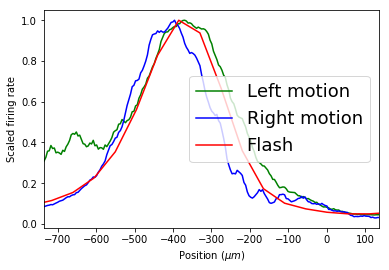

Calculating intercellular correlations...


100%|██████████| 6/6 [02:20<00:00, 23.47s/it]


Mean intercellular: 0.34660130362252406
Std intercellular: 0.15563803872188348
Min intercellular: 0.10235924279410678
Max intercellular: 0.5340475458811842
Layer 0 correlation map


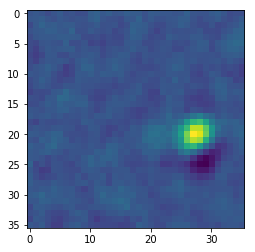

Layer 1 correlation map


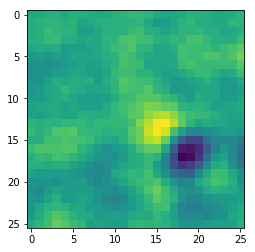

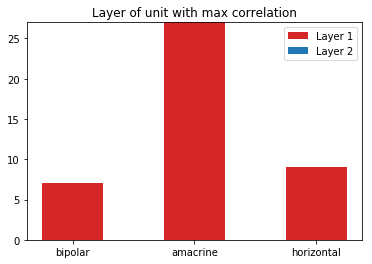

Receptive field of model cell in Layer 0


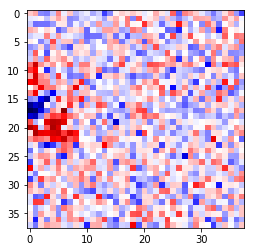

Receptive field of model cell in Layer 1


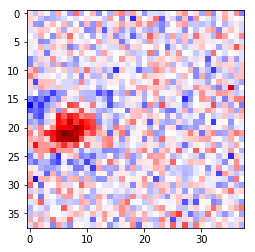

Memory Used: 23203.77 memory
Completed in 218.5126826763153 seconds





Folder: scaleshift/scaleshift_17_lr1e-05_l11e-06_l20.001
Final Loss: -2.7523635800247996
Final Val: -1.6626795008778572
Final Val Acc: 0.21973221004009247
Final Test Acc: 0.6117368034110647


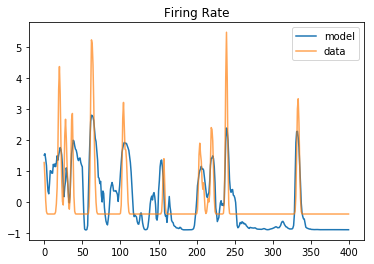

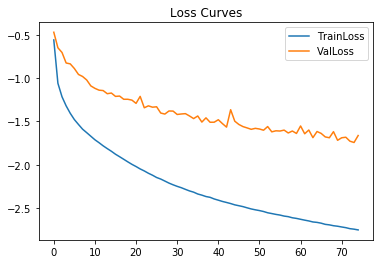

100%|██████████| 10/10 [00:00<00:00, 109.32it/s]
51it [00:00, 271.74it/s]


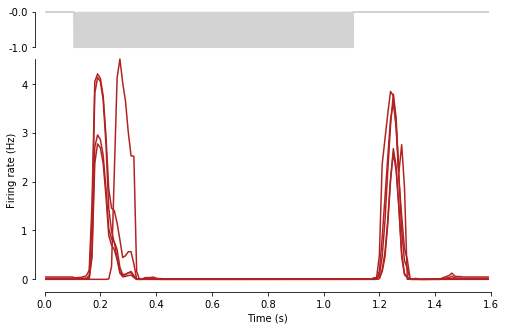

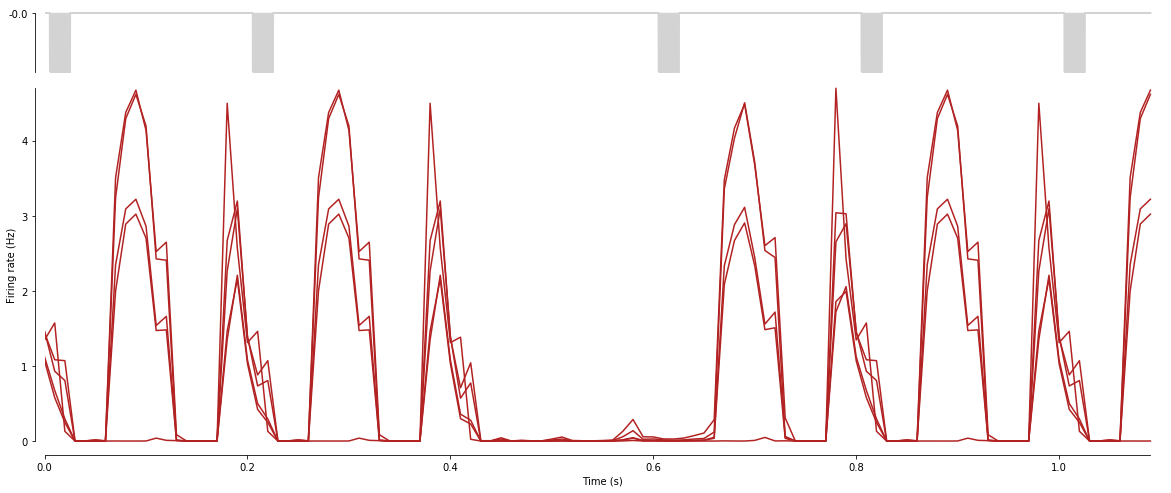

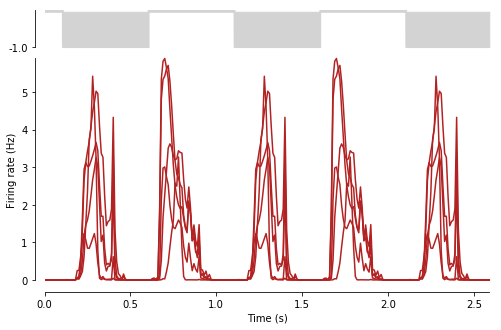

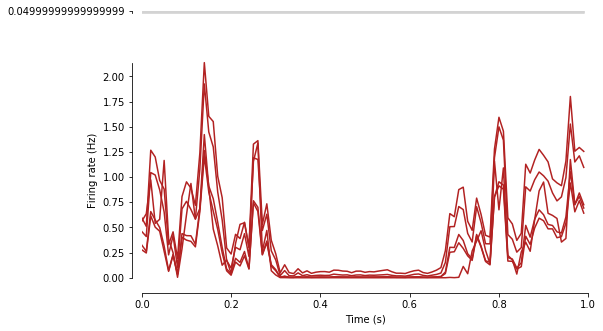

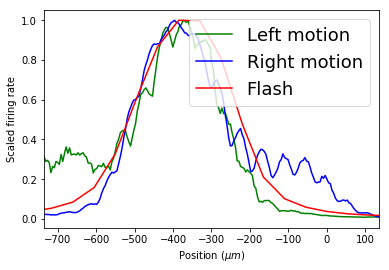

Calculating intercellular correlations...


100%|██████████| 6/6 [02:20<00:00, 23.59s/it]


Mean intercellular: 0.3344658879232397
Std intercellular: 0.1267422476651397
Min intercellular: 0.1344035267914405
Max intercellular: 0.5148012472633996
Layer 0 correlation map


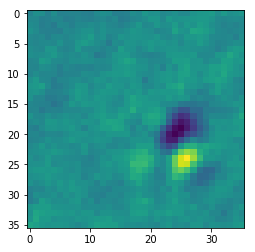

Layer 1 correlation map


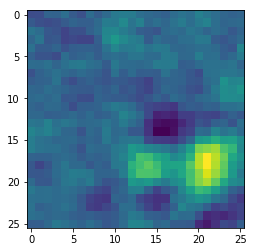

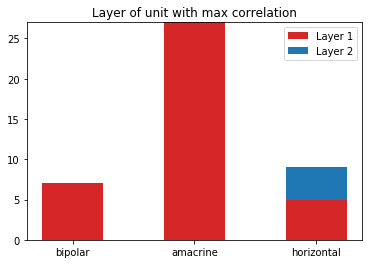

Receptive field of model cell in Layer 0


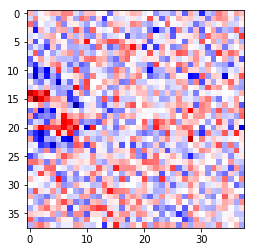

Receptive field of model cell in Layer 1


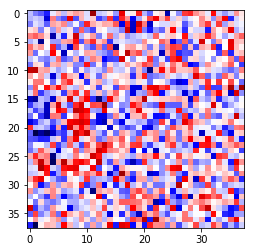

Memory Used: 23203.77 memory
Completed in 220.25582265853882 seconds





Folder: scaleshift/scaleshift_1_lr0.001_l10.001_l20.001
Final Loss: nan
Final Val: nan
Final Val Acc: nan
Final Test Acc: nan


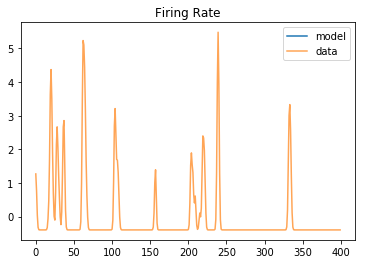

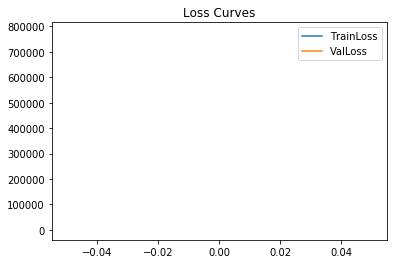

ValueError: Axis limits cannot be NaN or Inf

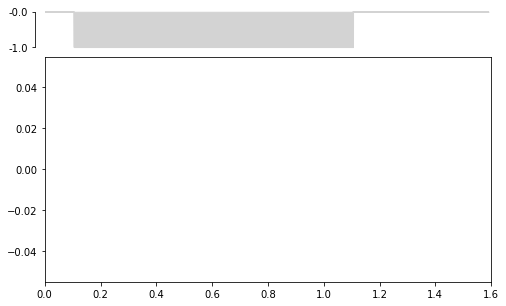

In [17]:
# load the losses
print("Using layers:", " and ".join(conv_layers))
for folder in sorted(model_folders):
    os.mkdir(folder+"_Analysis")
    readme = open(os.path.join(folder+"_Analysis", "README.txt"), "wb")
    starttime = time.time()
    losses = []
    val_losses = []
    val_accs = []
    for i in range(n_epochs):
        file = "../training_scripts/"+folder+"/test_epoch_{0}.pth".format(i)
        try:
            with open(file, "rb") as fd:
                temp = torch.load(fd)
            losses.append(temp['loss'])
            val_losses.append(temp['val_loss'])
            val_accs.append(temp['val_acc'])
        except:
            break
    bn_cnn = temp['model']
    bn_cnn = bn_cnn.to(DEVICE)
    bn_cnn.eval()
    print("Folder:", folder)
    print("Final Loss:", losses[-1])
    readme.write("Final Loss:" + losses[-1])
    print("Final Val:", val_losses[-1])
    readme.write("Final Val:" + val_losses[-1])
    print("Final Val Acc:", val_accs[-1])
    readme.write("Final Val Acc:" + val_accs[-1])
    if(math.isnan(losses[-1]) or math.isnan(val_losses[-1]) or math.isnan(val_accs[-1])):
        print("NaN results, continuing...\n\n\n\n")
        continue
    model_response = bc.batch_compute_model_response(test_data.X, bn_cnn, 500)    
    avg_test_acc = np.mean([scipy.stats.pearsonr(model_response['output'][:, i], test_data.y[:, i])[0] for i in range(len(cells))])
    if math.isnan(avg_test_acc):
        print("NaN results, continuing...\n\n\n\n")
        continue
    print("\nFinal Test Acc:", avg_test_acc)
    readme.write("\nFinal Test Acc:" + avg_test_acc)
    with open("../training_scripts/"+folder+"/hyperparams.txt", 'a') as f:
        f.write("\nTest Ganglion Cell Correlation: " + str(avg_test_acc))
    if losses[-1] < best_loss:
        best_loss = losses[-1]
        best_folder_by_loss = folder
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        best_folder_by_val_loss = folder
    if val_accs[-1] > best_val_acc:
        best_val_acc = val_accs[-1]
        best_folder_by_val_acc = folder
    if avg_test_acc > best_test_acc:
        best_test_acc = avg_test_acc
        best_folder_by_test_acc = folder
    plt.plot(normalize(model_response['output'][:400, 0]))
    plt.plot(normalize(test_data.y[:400,0]), alpha=.7)
    plt.legend(["model", "data"])
    plt.title("Firing Rate")
    plt.show()
    plt.save_fig(os.path.join(folder+"_Analysis", "firingrate.png"))
    plt.plot(losses)
    plt.plot(val_losses)
    plt.legend(["TrainLoss", "ValLoss"])
    plt.title("Loss Curves")
    plt.ylim([-6, 6])
    plt.show()
    plt.save_fig(os.path.join(folder+"_Analysis", "losscurves.png"))
    retinal_phenomena_figs(bn_cnn)
    plt.show()
    
    
    if avg_test_acc < .5 or losses[-1] > 1:
        print("Skipping further analysis due to poor results...\n\n\n\n")
        continue
    print("Calculating intercellular correlations...")
    # Computes the model responses for each stimulus 
    # and interneuron type labels y_true (0 for bipolar, 1 for amacrine, 2 for horizontal)
    y_true = []
    filter_length = 40
    model_responses = []
    for i in range(len(files)):
        file_name = files[i]
        if 'bipolar' in file_name:
            for j in range(num_pots[i]):
                y_true.append(0)
        elif 'amacrine' in file_name:
            for j in range(num_pots[i]):
                y_true.append(1)
        else:
            for j in range(num_pots[i]):
                y_true.append(2)
        stim = stims[i]
        padded_stim = intracellular.pad_to_edge(scipy.stats.zscore(stim))
        model_responses.append(bc.batch_compute_model_response(stimuli.concat(padded_stim),bn_cnn,  500))
    
    # uses classify to get the most correlated cell/layer/subtype for each interneuron recording. 
    # Stored in all_cell_info. y_pred does a baseline "classification": record the convolutional 
    # layer that the most correlated cell is in.
    # See intracellular.py for more info
    # This takes a really long time to run. 
    all_cell_info = []
    y_pred = []
    for i in tqdm(range(len(files))):
        for j in range(mem_pots[i].shape[0]):
            model_response = model_responses[i]
            stim = stims[i]
            potential = mem_pots[i][j]
            cell_info = intracellular.classify(potential, model_response, stim.shape[0], layer_keys=conv_layers)
            all_cell_info.append(cell_info)
            layer = cell_info[0]
            if layer == conv_layers[0]:
                y_pred.append(0)
            else:
                y_pred.append(1)
    # Average intracellular correlation. RIP.
    avg_intr_cor = np.mean([all_cell_info[i][3] for i in range(7)])
    print("Mean intercellular:", avg_intr_cor)
    readme.write("Mean intercellular:" + avg_intr_cor)
    print("Std intercellular:", np.std([all_cell_info[i][3] for i in range(7)]))
    print("Min intercellular:", np.min([all_cell_info[i][3] for i in range(7)]))
    print("Max intercellular:", np.max([all_cell_info[i][3] for i in range(7)]))
    if avg_intr_cor > best_intr_cor:
        best_intr_cor = avg_intr_cor
        best_folder_by_intr_cor = folder
    
    # Make correlation maps
    model_response = model_responses[3]
    potential = mem_pots[3][4]
    print("Layer 0 correlation map")
    plt.imshow(intracellular.correlation_map(potential, model_response[conv_layers[0]][:, 4]))
    plt.show()
    print("Layer 1 correlation map")
    plt.imshow(intracellular.correlation_map(potential, model_response[conv_layers[1]][:, 4]))
    plt.show()
    
    bipolar_layer1 = 0
    bipolar_layer2 = 0
    amacrine_layer1 = 0
    amacrine_layer2 = 0
    horizontal_layer1 = 0
    horizontal_layer2 = 0
    for index in range(len(y_true)):
        if y_true[index] == 0 and y_pred[index] == 0:
            bipolar_layer1 += 1
        elif y_true[index] == 0 and y_pred[index] == 1:
            bipolar_layer2 += 1
        elif y_true[index] == 1 and y_pred[index] == 0:
            amacrine_layer1 += 1
        elif y_true[index] == 1 and y_pred[index] == 1:
            amacrine_layer2 += 1
        elif y_true[index] == 2 and y_pred[index] == 0:
            horizontal_layer1 += 1
        else:
            horizontal_layer2 += 1

    layer1 = [bipolar_layer1, amacrine_layer1, horizontal_layer1]
    layer2 = [bipolar_layer2, amacrine_layer2, horizontal_layer2]
    ind = np.arange(3)
    width = 0.5
    p1 = plt.bar(ind, layer1, width, color='#d62728')
    p2 = plt.bar(ind, layer2, width, bottom=layer1)
    plt.xticks(ind, ('bipolar', 'amacrine', 'horizontal'))
    plt.legend((p1[0], p2[0]), ('Layer 1', 'Layer 2'))
    plt.title("Layer of unit with max correlation")
    plt.show()
    
    stimulus_num = 3
    model_cell_response = model_responses[stimulus_num][conv_layers[0]][:, 1, 15, 0]
    stimulus = stims[stimulus_num]
    filter_length = 40
    # Plot the receptive field for a model cell
    print("Receptive field of model cell in Layer 0")
    rc_model, lags_model = ft.revcorr(scipy.stats.zscore(stimulus)[filter_length:], model_cell_response, nsamples_before=0, nsamples_after=filter_length)
    spatial_model, temporal_model = ft.decompose(rc_model)
    img =plt.imshow(spatial_model, cmap = 'seismic', clim=[-np.max(abs(spatial_model)), np.max(abs(spatial_model))])
    plt.show()
    
    print("Receptive field of model cell in Layer 1")
    model_cell_response = model_responses[stimulus_num][conv_layers[1]][:, 1, 15, 0]
    stimulus = stims[stimulus_num]
    # Plot the receptive field for a model cell
    rc_model, lags_model = ft.revcorr(scipy.stats.zscore(stimulus)[filter_length:], model_cell_response, nsamples_before=0, nsamples_after=filter_length)
    spatial_model, temporal_model = ft.decompose(rc_model)
    img = plt.imshow(spatial_model, cmap = 'seismic', clim=[-np.max(abs(spatial_model)), np.max(abs(spatial_model))])
    plt.show()
    
    gc.collect()
    max_mem_used = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
    print("Memory Used: {:.2f} memory".format(max_mem_used / 1024))
    print("Completed in", time.time()-starttime, "seconds")
    print("\n\n\n\n")
    
print("Best by validation loss:", best_folder_by_val_loss)
print("Best by training loss:", best_folder_by_loss)
print("Best by val accuracy:", best_folder_by_val_acc)
print("Best by test accuracy:", best_folder_by_test_acc)

In [12]:
print("Best by validation loss:", best_folder_by_val_loss)
print("Best by training loss:", best_folder_by_loss)
print("Best by val accuracy:", best_folder_by_val_acc)
print("Best by test accuracy:", best_folder_by_test_acc)
print("Best by intracell correlation:", best_folder_by_intr_cor)

Best by validation loss: scaleshift/scaleshift_2_lr0.001_l11.5e-05_l20.01
Best by training loss: scaleshift/scaleshift_5_lr0.001_l11e-06_l20.001
Best by val accuracy: scaleshift/scaleshift_6_lr0.0001_l10.001_l20.01
Best by test accuracy: scaleshift/scaleshift_2_lr0.001_l11.5e-05_l20.01
